## Automating Fabric:  Maintaining workspace icon images
Notebook demonstrating how to maintain workspace icon images programmatically.  
The notebook uses the Fabric icons from Marc Lelijveld's blog post on [Designing Architectural Diagrams with the Latest Microsoft Fabric Icons](https://data-marc.com/2023/07/10/designing-architectural-diagrams-with-the-latest-microsoft-fabric-icons/). 

**_Disclaimer:_** This solution uses a non-documented and unofficial Microsoft endpoint for fetching and updating workspace metadata in Microsoft Fabric/Power BI. Since this is not an officially supported API, it may change without notice, which could impact the functionality of this approach. Use it with that in mind, and feel free to experiment!

In [1]:
pip install pillow cairosvg

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 3, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sempy.fabric as fabric
import cairosvg
import io
import base64
import re
import json
import requests
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

client = fabric.FabricRestClient()

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 4, Finished, Available, Finished)

In [3]:
############################################################################################################
# Power BI / Fabric Workspace functions
############################################################################################################

def get_cluster_url():
    cluster_response = client.get("https://api.powerbi.com/v1.0/myorg/capacities")
    print(cluster_response.json())
    match = re.match(r"(https://[^/]+/)", cluster_response.json().get("@odata.context"))
    return match.group(1) if match else None

# Get cluster URL for use in metadata endpoints
cluster_base_url = get_cluster_url()

def get_workspace_metadata(workspace_id):
    response = client.get(f"{cluster_base_url}metadata/folders/{workspace_id}")
    return response.json()


def set_workspace_icon(workspace_id, base64_png):
    icon = f"data:image/png;base64,{base64_png}" if base64_png else ""
    payload = { "icon": icon }
    response = client.put(f"{cluster_base_url}metadata/folders/{workspace_id}", json = payload)
    response.raise_for_status()
    return response.json()


def get_workspaces():
    response = client.get(f"v1/workspaces")
    response.raise_for_status()
    return response.json()

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 5, Finished, Available, Finished)

{'@odata.context': 'https://wabi-north-europe-j-primary-redirect.analysis.windows.net/v1.0/myorg/$metadata#capacities', 'value': [{'id': '675325CA-8C88-40EE-9B45-2854788AB177', 'displayName': 'msfabricsmall', 'admins': ['pg@kapacity.dk'], 'sku': 'F4', 'state': 'Suspended', 'capacityUserAccessRight': 'Admin', 'region': 'North Europe', 'users': []}, {'id': '7520DBCC-9220-4E1C-9226-756491C577D4', 'displayName': 'fabtwodayfabcontest', 'admins': ['pg@kapacity.dk'], 'sku': 'F2', 'state': 'Suspended', 'capacityUserAccessRight': 'Admin', 'region': 'North Europe', 'users': []}, {'id': '9B8EF30C-3136-40E6-827F-7986AA6E929F', 'displayName': 'fabtwodayfabconprod', 'admins': ['pg@kapacity.dk'], 'sku': 'F2', 'state': 'Suspended', 'capacityUserAccessRight': 'Admin', 'region': 'North Europe', 'users': []}, {'id': 'C3DA72F0-A794-434B-8AA4-2370AD2DFB6C', 'displayName': 'fabtwodayfabcondev', 'admins': ['pg@kapacity.dk'], 'sku': 'F2', 'state': 'Suspended', 'capacityUserAccessRight': 'Admin', 'region': 'No

In [4]:
############################################################################################################
# Demo specific functions
############################################################################################################

icon_display_size = "25"
default_icon = f"<img height='{icon_display_size}' src='https://content.powerapps.com/resource/powerbiwfe/images/artifact-colored-icons.663f961f5a92d994a109.svg#c_group_workspace_24' />"

def convert_svg_base64_to_png_base64(base64_svg):
    svg_data = base64.b64decode(base64_svg)
    png_bytes = cairosvg.svg2png(bytestring=svg_data)
    base64_png = base64.b64encode(png_bytes).decode()

    return base64_png


def fill_svg(base64_svg, fill_color):
    svg_data = base64.b64decode(base64_svg).decode('utf-8')
    modified_svg = re.sub(r'fill="[^"]+"', f'fill="{fill_color}"', svg_data)
    return base64.b64encode(modified_svg.encode('utf-8')).decode('utf-8')


def filter_items(data, must_contain, either_contain):
    filtered_items = []
    
    for item in data['value']:
        display_name = item.get('displayName', '').lower()
        if must_contain.lower() not in display_name:
            continue  

        if any(sub.lower() in display_name for sub in either_contain):
            filtered_items.append(item)

    return filtered_items


def display_workspace_icons(workspaces):
    html = "<table width='100%'>"
    html += "<th style='text-align:left'>Workspace name</th><th style='text-align:left'>Workspace ID</th><th style='text-align:left; width:100px'>Old icon</th><th style='text-align:left; width:100px'>New icon</th>"
    for workspace in workspaces:
        html += f"<tr><th style='text-align:left'>{workspace.get('displayName')}</td>"
        html += f"<td style='text-align:left'>{workspace.get('id')}</td>"
        iconUrl = get_workspace_metadata(workspace.get('id')).get('iconUrl')
        existing_icon = f"<img height='{icon_display_size}' src='{cluster_base_url}{iconUrl}'/>" if iconUrl else default_icon
        html += f"<td style='text-align:left'>{existing_icon}</td>"
        new_icon = workspace.get('icon_base64img')
        new_icon = f"<img height='{icon_display_size}' src='data:image/png;base64,{new_icon}' />" if new_icon else default_icon
        html += f"<td style='text-align:left'>{new_icon}</td></tr>"
    
    displayHTML(html)   


def get_marcs_fabric_icons():
    url = "https://raw.githubusercontent.com/marclelijveld/Fabric-Icons/main/Draw.io_Fabric-Icons.xml"

    response = requests.get(url)
    response.raise_for_status()

    try:
        mxlibrary_data = json.loads(ET.fromstring(response.text).text)
    except (json.JSONDecodeError, ET.ParseError):
        return {}

    img_dict = {}

    for item in mxlibrary_data:
        title = item.get("title", "No Title")
        xml_item = item.get("xml", "")
        
        try:
            root = ET.fromstring(xml_item)
        except ET.ParseError:
            img_dict[title] = "Invalid XML"
            continue
        
        base64_string = next(
            (match.group(1) for cell in root.findall(".//mxCell")
             if (match := re.search(r"image=data:image/[^,]+,([^;]+)", cell.get("style", "")))),
            "No Base64 found"
        )
        
        img_dict[title] = base64_string

    return img_dict


def add_letter_to_base64_png(base64_png, letter, font_size=20, text_color="black", bold=False):
    image_data = base64.b64decode(base64_png)
    image = Image.open(io.BytesIO(image_data))

    draw = ImageDraw.Draw(image)
    
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
        
    padding = 0
    text_bbox = draw.textbbox((0, 0), letter, font=font)  # Get bounding box
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    text_x = image.width - text_width - padding
    text_y = padding

    if bold:
        for offset in [(0, 0), (1, 0), (0, 1), (1, 1)]:
            draw.text((text_x + offset[0], text_y + offset[1]), letter, font=font, fill=text_color)
    else:
        draw.text((text_x, text_y), letter, font=font, fill=text_color)

    output_buffer = io.BytesIO()
    image.save(output_buffer, format="PNG")
    new_base64_png = base64.b64encode(output_buffer.getvalue()).decode("utf-8")

    return new_base64_png

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 6, Finished, Available, Finished)

In [ ]:
# Print available icons
for title in get_marcs_fabric_icons().keys():
    print(title)

In [5]:
all_workspaces = get_workspaces()

must_contain = "PeerInsights"
either_contain = ["dev","tst", "prd"]

workspaces = filter_items(all_workspaces, must_contain, either_contain)

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 7, Finished, Available, Finished)

In [ ]:
# Print filtered workspaces
print(json.dumps(workspaces, indent=4))

In [6]:
# Workspace icon definition. Setting the icons to None will delete the existing icon of the workspaces specified.

workspace_icon_def = {
    "icons": {
        "prepare": "Notebook",
        "ingest": "Pipelines",
        "store": "Lakehouse",
        "serve": "Dataset"
    },
    "color_overlays": {
        "dev": "#1E90FF",   # Blue
        "tst": "#FFA500",   # Orange
        "prd": "#008000"    # Green    
    },
    # "text_overlays": {
    #     "dev": "D",
    #     "tst": "T",
    #     "prd": "P"
    # }
}

# Reset workspace icons by setting the icon to None
# workspace_icon_def = {
#     "icons": {
#         "prepare": None,
#         "ingest": None,
#         "store": None,
#         "serve": None
#     }
# }

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 8, Finished, Available, Finished)

In [7]:
fabric_icons = get_marcs_fabric_icons()

for workspace in workspaces:
    display_name = workspace['displayName'].lower()

    # Check if any of the keys in 'icons' appear in displayName
    for icon_key, icon_value in workspace_icon_def['icons'].items():
        if icon_key in display_name:
            workspace["icon"] = icon_value
            workspace_icon = fabric_icons.get(icon_value)
            break 

    color_overlays = workspace_icon_def.get('color_overlays', {})

    if isinstance(color_overlays, dict) and color_overlays:
        for color_key, color_value in color_overlays.items():
            if color_key in display_name:
                workspace_icon = fill_svg(workspace_icon, color_value)
                break 
    
    workspace_icon = convert_svg_base64_to_png_base64(workspace_icon) if workspace_icon else None

    text_overlays = workspace_icon_def.get('text_overlays', {})
    if isinstance(text_overlays, dict) and text_overlays:
        for overlay_key, overlay_value in text_overlays.items():
            if overlay_key in display_name:
                workspace_icon = add_letter_to_base64_png(workspace_icon, overlay_value, 15, "black", False)
                break 

    workspace["icon_base64img"] = workspace_icon 
    

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 9, Finished, Available, Finished)

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 10, Finished, Available, Finished)

e5a6f94c-1740-4969-89da-b44d5c397778,,
1c55458e-ec95-48a2-af30-08a4606b17c2,,
8a0ed205-1dde-4b18-b0c0-2c58dfa1279a,,
bbb64606-a356-4279-8ae9-aef0033507e0,,
d6a77bb0-a9cc-43a3-afd7-46020b934cfa,,
9edba139-8b4c-48f7-b824-901507629a49,,
07c339c0-cbec-4e62-8ee1-b3700f98e3a0,,
73d596b1-204a-4041-85e2-0e75b3f9256c,,
af107683-5b5a-41a3-9368-86bfd0507ac2,,
7d87a51d-d4bb-472b-82a6-75c5262d1711,,
d3784b35-cebf-4ce4-97b9-111823d70df2,,

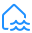
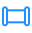
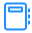
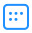
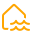
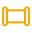
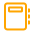
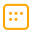
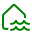
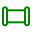
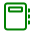
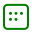

In [8]:
# Dry run - Display pre and post icons based on specified workspace filters and workspace icon definition. Will NOT update any icons!
display_workspace_icons(workspaces)

## Iterate workspaces and update icon
Let us run through the workspaces which match our search pattern and update the icons as we have specified in the workspace icon definition json

In [9]:
for workspace in workspaces:
    set_workspace_icon(workspace.get('id'), workspace.get('icon_base64img'))

StatementMeta(, bb12ff9d-cfee-44fb-8bb0-255327a696e7, 11, Finished, Available, Finished)